In [4]:
import os
import numpy as np
import logging
import faiss
from vasili_helpers import *
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
xb, xq, gt, metric = load_deep10M(f"/pub/scratch/vmageirakos/datasets/ann-fvecs/deep-96-angular")
xb.shape
xq.shape

Loading deep10M...done


(10000000, 96)

(10000, 96)

In [9]:
faiss.omp_get_max_threads()
# faiss.omp_set_num_threads(1)

128

In [3]:
xb, xq, xt, gt, metric = load_sift1M(f"/pub/scratch/vmageirakos/datasets/ann-fvecs/sift-128-euclidean")

Loading sift1M...done


dataset shape:
xb.shape=(1000000, 128)
gt.shape=(10000, 100)
xq.shape=(10000, 128)


In [ ]:
k=100
nlist = 1000
nprobe = 20
d = xb.shape[1]
compute_GT = True
SEED = int(time.time())

### init trained index
# ndex for coarse quantization
trained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
trained_index = faiss.IndexIVFFlat(trained_quantizer, d, nlist, faiss.METRIC_L2)
trained_index.cp.seed = SEED
trained_index.cp.niter= 25
trained_index.cp.nredo = 1
trained_index.verbose=True
# Train the IVF index
trained_index.train(xb)
trained_index.add(xb)

### init untrained index
untrained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
untrained_index = faiss.IndexIVFFlat(untrained_quantizer, d, nlist, faiss.METRIC_L2)
untrained_index.cp.seed = SEED #int(time.time())
untrained_index.cp.niter= 0
untrained_index.verbose=True
untrained_index.train(xb)
untrained_index.add(xb)


### init untrained index
train1_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
train1_index = faiss.IndexIVFFlat(train1_quantizer, d, nlist, faiss.METRIC_L2)
train1_index.cp.seed = SEED
train1_index.cp.niter= 1
train1_index.verbose=True
train1_index.train(xb)
train1_index.add(xb)

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


In [30]:
index_to_crack = faiss.clone_index(untrained_index) # each run should start from same point because crack is in-place

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


(8779, 128)

(621, 128)

- Total number of unique centroids visited: 220
- % of total centroids: 22.0 %


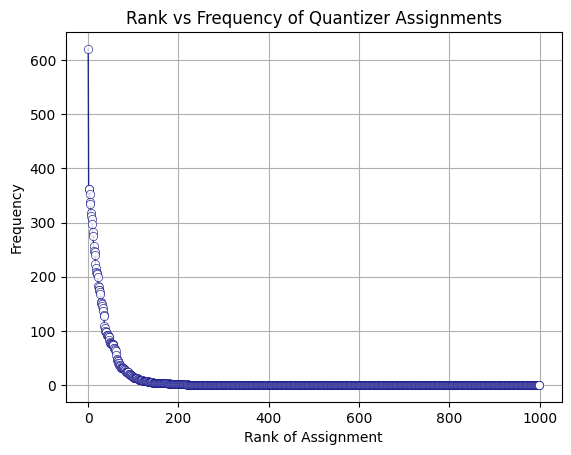

In [21]:
_, selected_vectors, gt_selected_vectors, _ = get_skewed_dataset(xb, 
                                skew_on_centroid=0, 
                                nlist=1000, 
                                compute_GT = True, 
                                nearest_cents_to_include=1,
                                seed=SEED,
                                )
xq.shape
selected_vectors.shape

vvids = get_centroid_ids_per_query(
    # index_ivf, 
    trained_index, 
    selected_vectors, 
    # selected_vectors[0:1,:], 
    nprobe=20, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

In [22]:
xq = selected_vectors
gt = gt_selected_vectors

In [31]:
topK = 100
batch_size=1
nq, d = xq.shape
I = np.empty((nq, topK), dtype="int32")
D = np.empty((nq, topK), dtype="int32")
i0 = 0
limit_crack = 100

while i0 < nq:#nq:
    t_batch_start = time.perf_counter()

    if i0 + batch_size < nq:
        i1 = i0 + batch_size
    else:
        i1 = nq
    if limit_crack is not None and limit_crack <= i0:
        CRACK=False
    else:
        CRACK=True
    if not CRACK: break
    index_to_crack, Di, Ii, timings, c_visited_ids, d_nprobe = search_and_crack_single_query(
        index_to_crack,
        xq[i0:i1],
        nprobe=nprobe,
        k=topK,
        inner_km_niter=1,
        CRACK=CRACK,
        # plot_boxplot=True,
        # limit_crack=1,
        dynamic_nprobe_factor=2,
        # DEBUG=True,
        )
    I[i0:i1] = Ii
    D[i0:i1] = Di

    perQ_recall_1 = compute_recall(Ii, gt[i0:i1,:].reshape(1,-1), k=1)
    perQ_recall_10 = compute_recall(Ii, gt[i0:i1,:].reshape(1,-1), k=10)
    perQ_recall_100  = compute_recall(Ii, gt[i0:i1,:].reshape(1,-1), k=100)
    i0 = i1

In [25]:
ivf_stats = faiss.cvar.indexIVF_stats

In [ ]:
nprobe = 20
nprobe_cracked  = 20 # CHEF NOTE: this is hard to set depends how you broke it up
k=100

print()
print("untrained")
ivf_stats.reset()
untrained_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev = untrained_index.search(selected_vectors, k)  # perform search
# distances, indices_prev = untrained_index.search(selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)  # perform search
untrained_nds = ivf_stats.ndis
print(f"untraied ndis = {ivf_stats.ndis}")
# Compute Recall@k
recall_at_k = compute_recall(indices_prev, gt_selected_vectors, k)
# recall_at_k = compute_recall(indices_prev, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")
print()


print("trained niter=1")
ivf_stats.reset()
train1_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev_trained_1 = train1_index.search(selected_vectors, k)  # perform search
# distances, indices_prev = trained_index.search(selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)  # perform search
once_trained_ndis = ivf_stats.ndis
print(f"trained ndis = {ivf_stats.ndis}")
recall_at_k = compute_recall(indices_prev_trained_1, gt_selected_vectors, k)
# recall_at_k = compute_recall(indices_prev, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")

print()
print("trained")
ivf_stats.reset()
trained_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev_trained = trained_index.search(selected_vectors, k)  # perform search
# distances, indices_prev = trained_index.search(selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)  # perform search
trained_ndis = ivf_stats.ndis
print(f"trained ndis = {ivf_stats.ndis}")
# Compute Recall@k
recall_at_k = compute_recall(indices_prev_trained, gt_selected_vectors, k)
# recall_at_k = compute_recall(indices_prev, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")


print()
print("index_to_crack")
ivf_stats.reset()
index_to_crack.nprobe = nprobe_cracked  # number of clusters to search
distances, idx = index_to_crack.search(selected_vectors, k)  # perform search
cracked_ndis = ivf_stats.ndis
# Compute Recall@k
print(f"{cracked_ndis=}")
recall_at_k = compute_recall(idx, gt_selected_vectors, k)
# recall_at_k = compute_recall(idx2, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")


untrained
untraied ndis = 13222067
Recall@100: 0.8060

trained niter=1
trained ndis = 10477456
Recall@100: 0.8459

trained
trained ndis = 10471862
Recall@100: 0.8860

index_to_crack
cracked_ndis=13357459
Recall@100: 0.8648


In [33]:
# cracked from untrained
print("vs trained full")
print(cracked_ndis)
print(cracked_ndis - trained_ndis) # trained
print((cracked_ndis - trained_ndis)/(trained_ndis) * 100, "%")
print("vs trained once")
print(cracked_ndis - once_trained_ndis) # untrained
print((cracked_ndis - once_trained_ndis)/(once_trained_ndis) * 100, "%")
print("vs untrained")
print(cracked_ndis - untrained_nds) # untrained
print((cracked_ndis - untrained_nds)/(untrained_nds) * 100 ,"%")

vs trained full
13357459
2885597
27.555720272096785 %
vs trained once
2880003
27.487617223112178 %
vs untrained
135392
1.0239851303128324 %


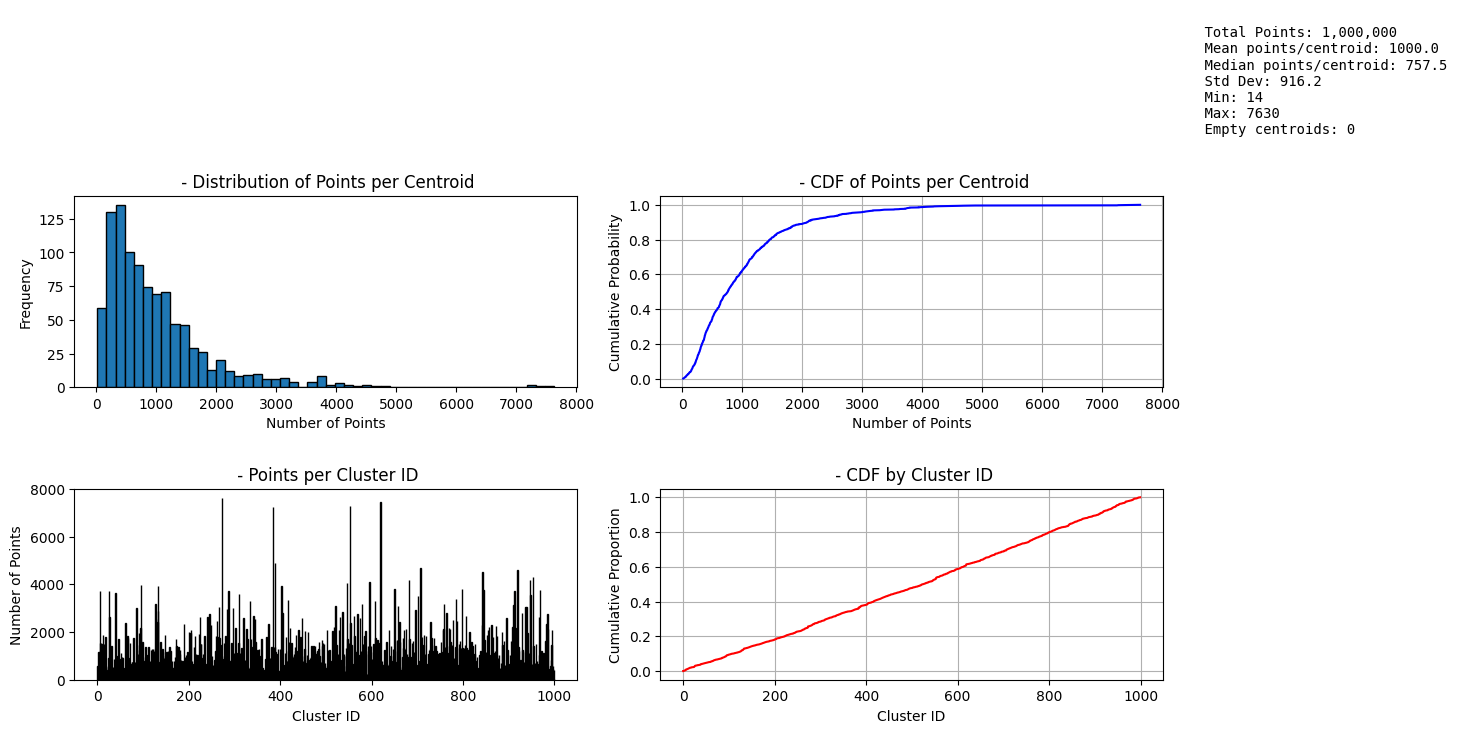

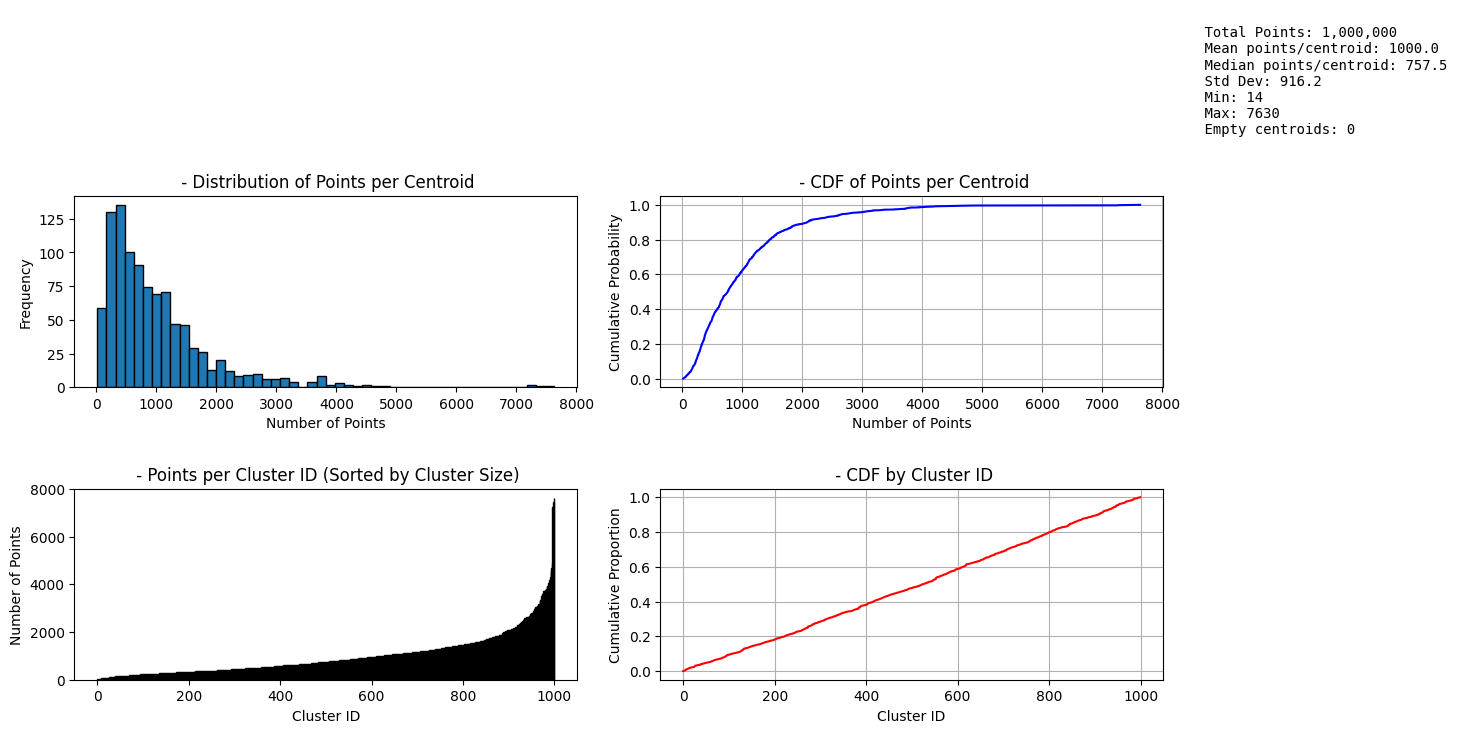

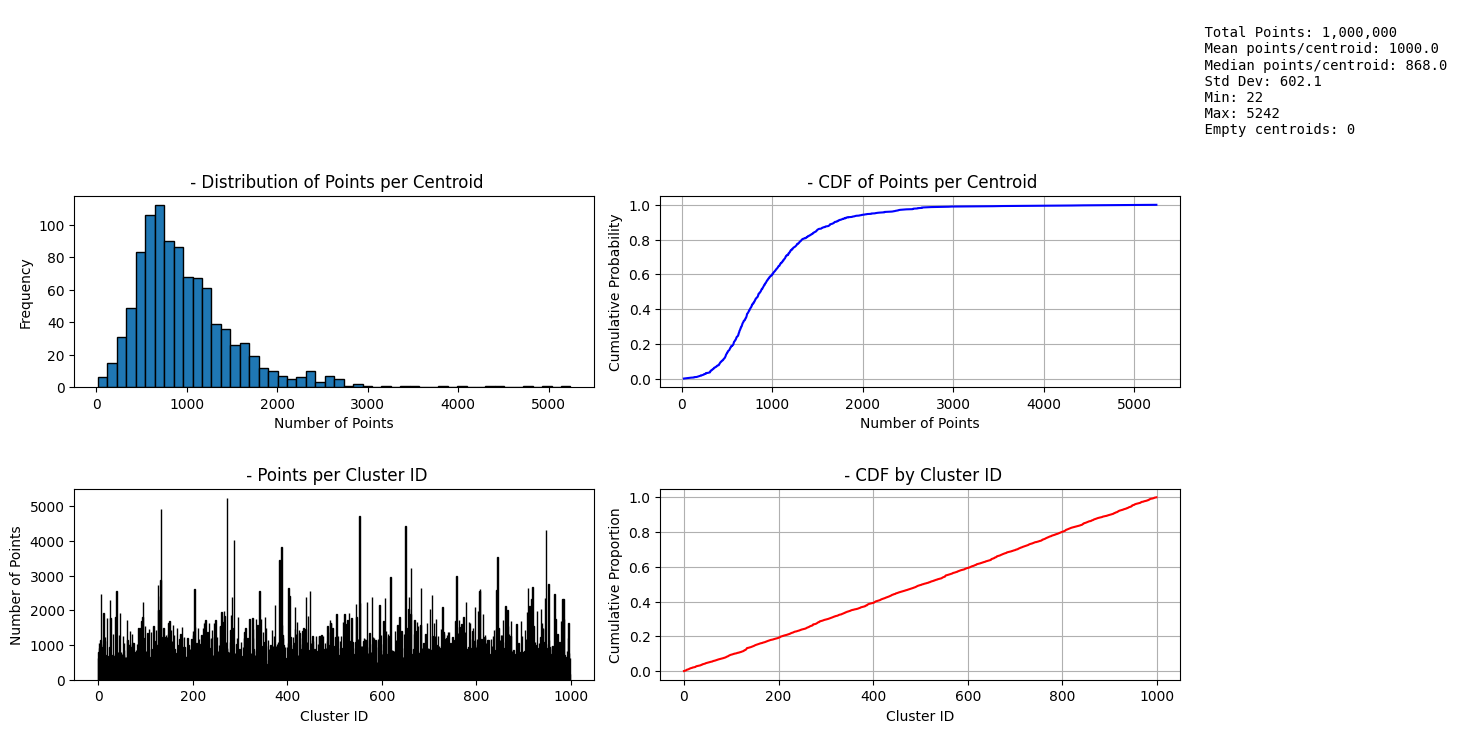

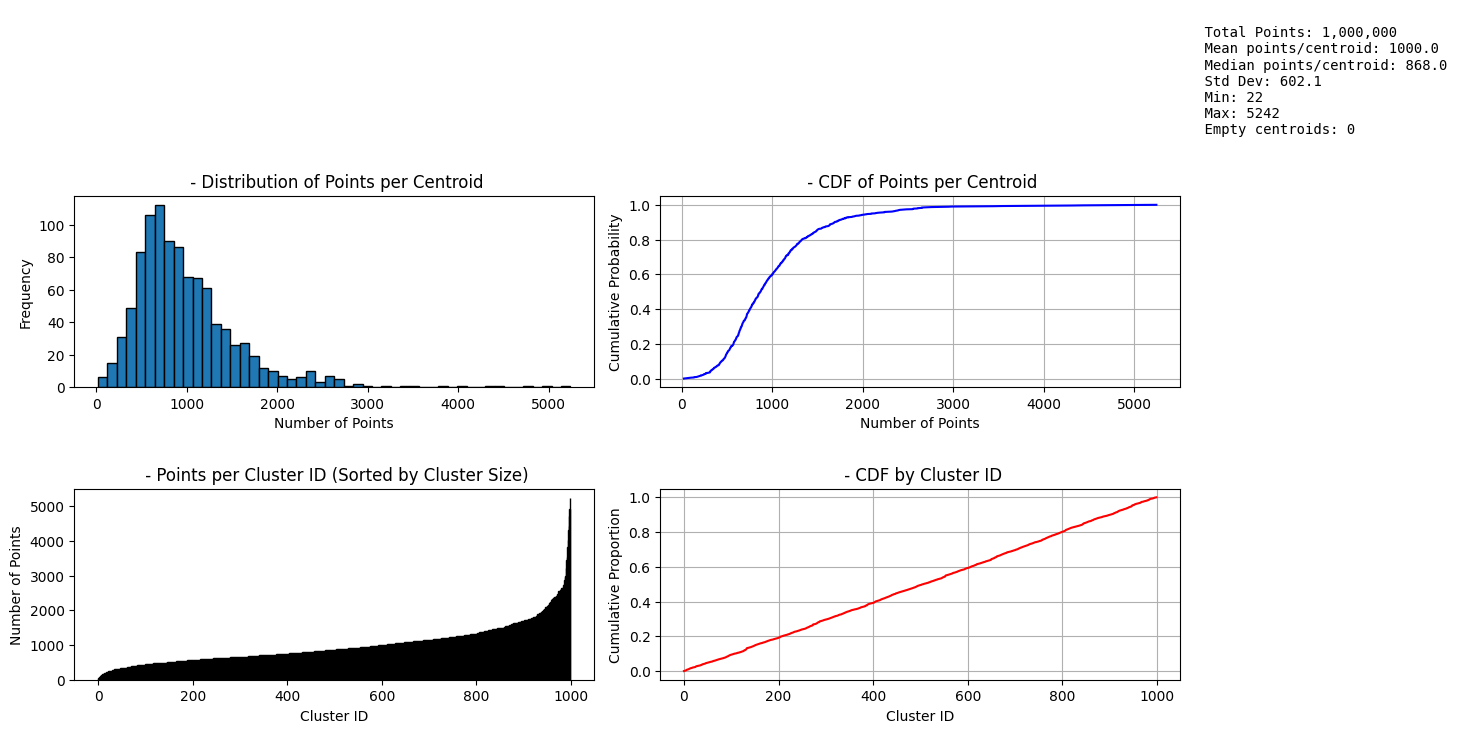

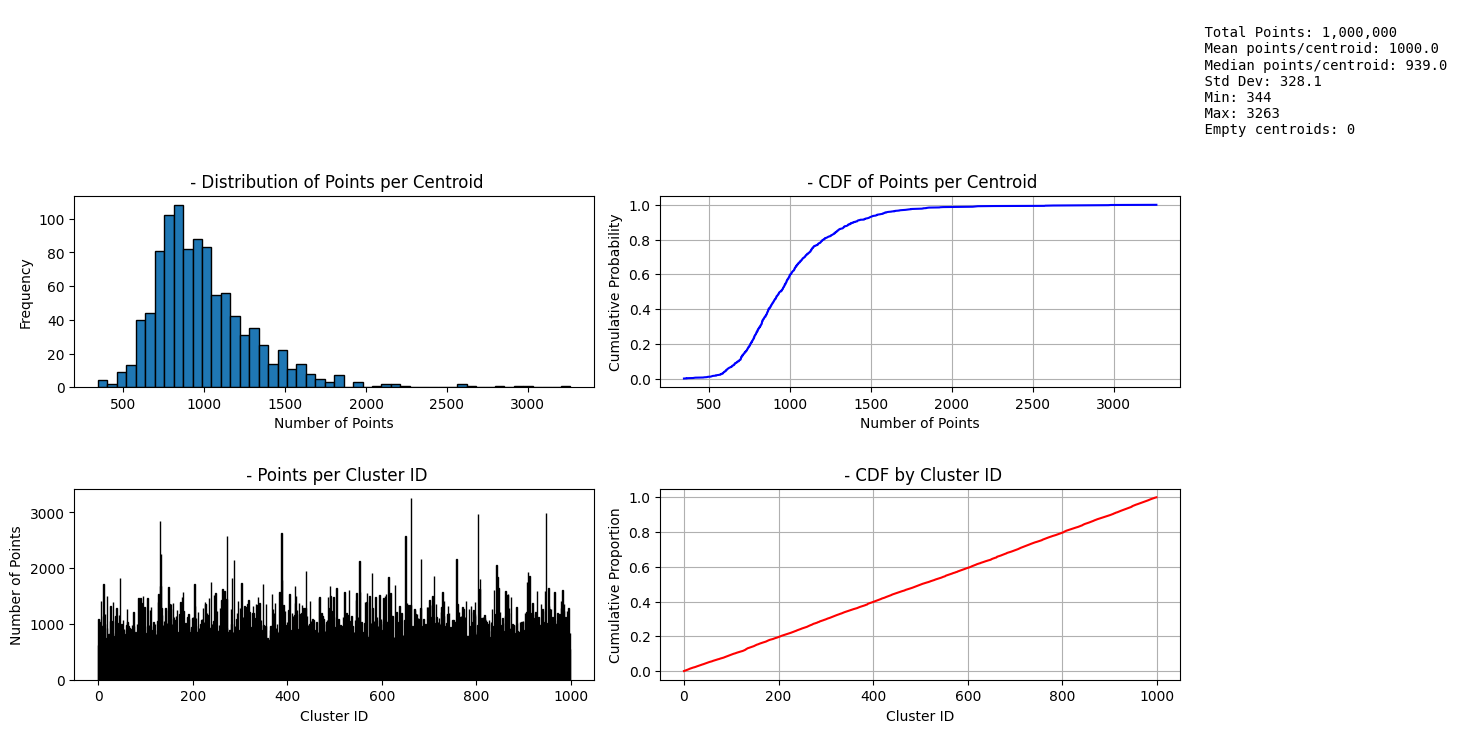

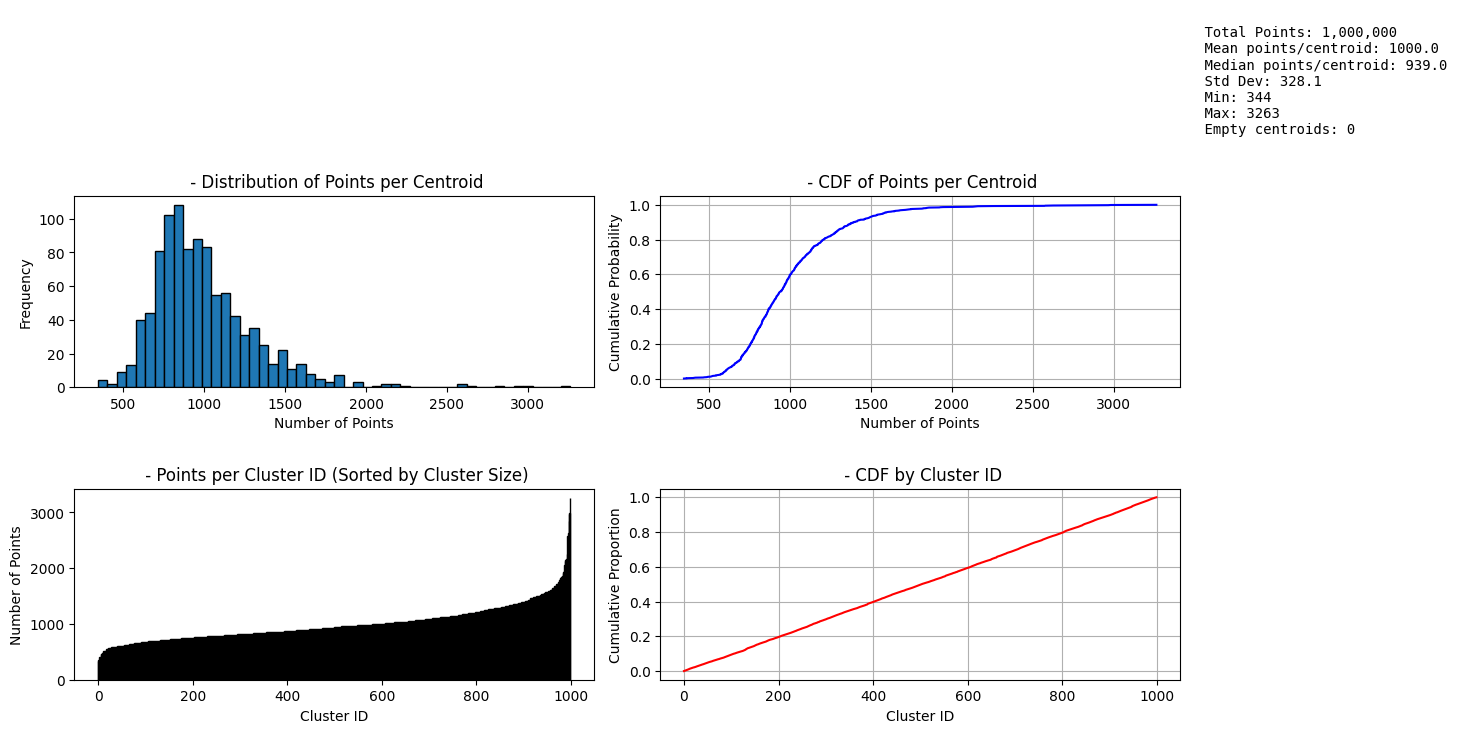

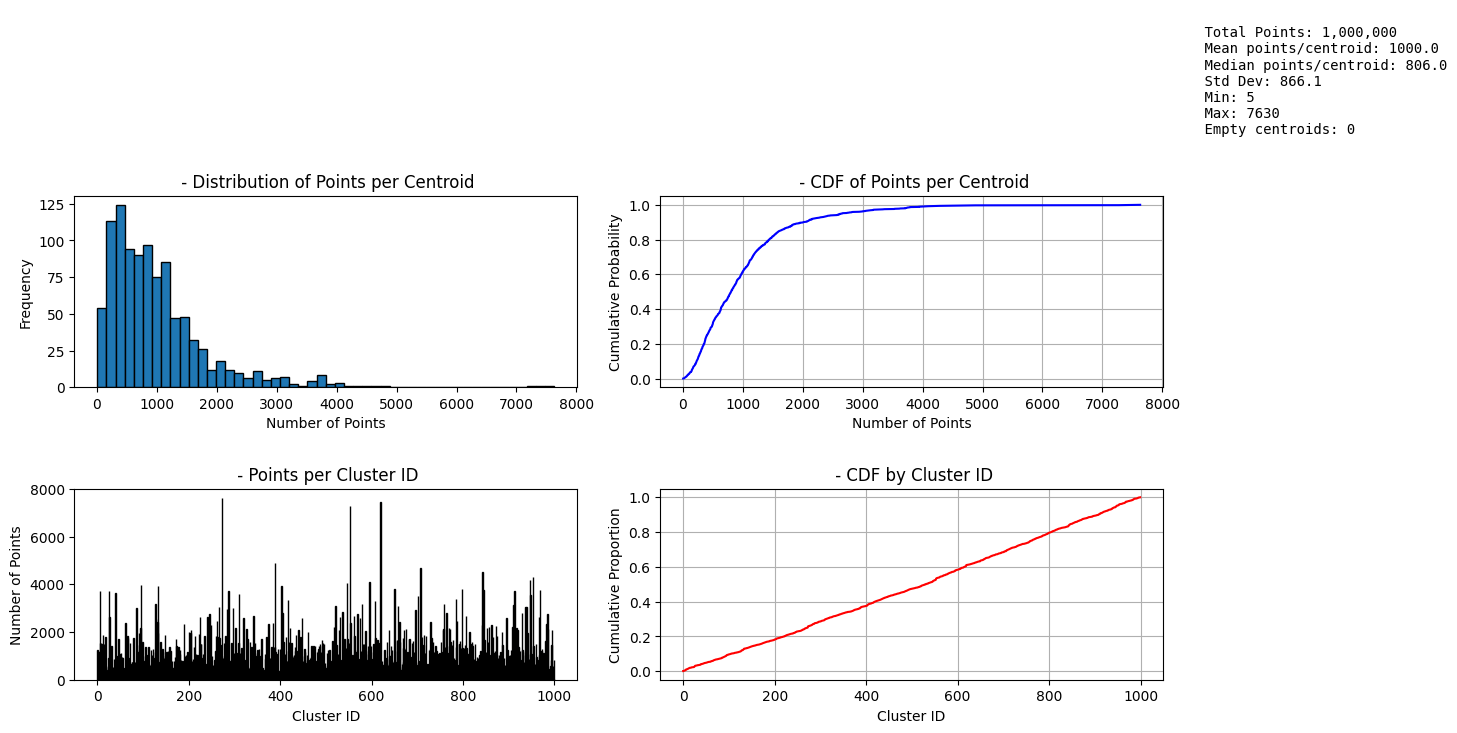

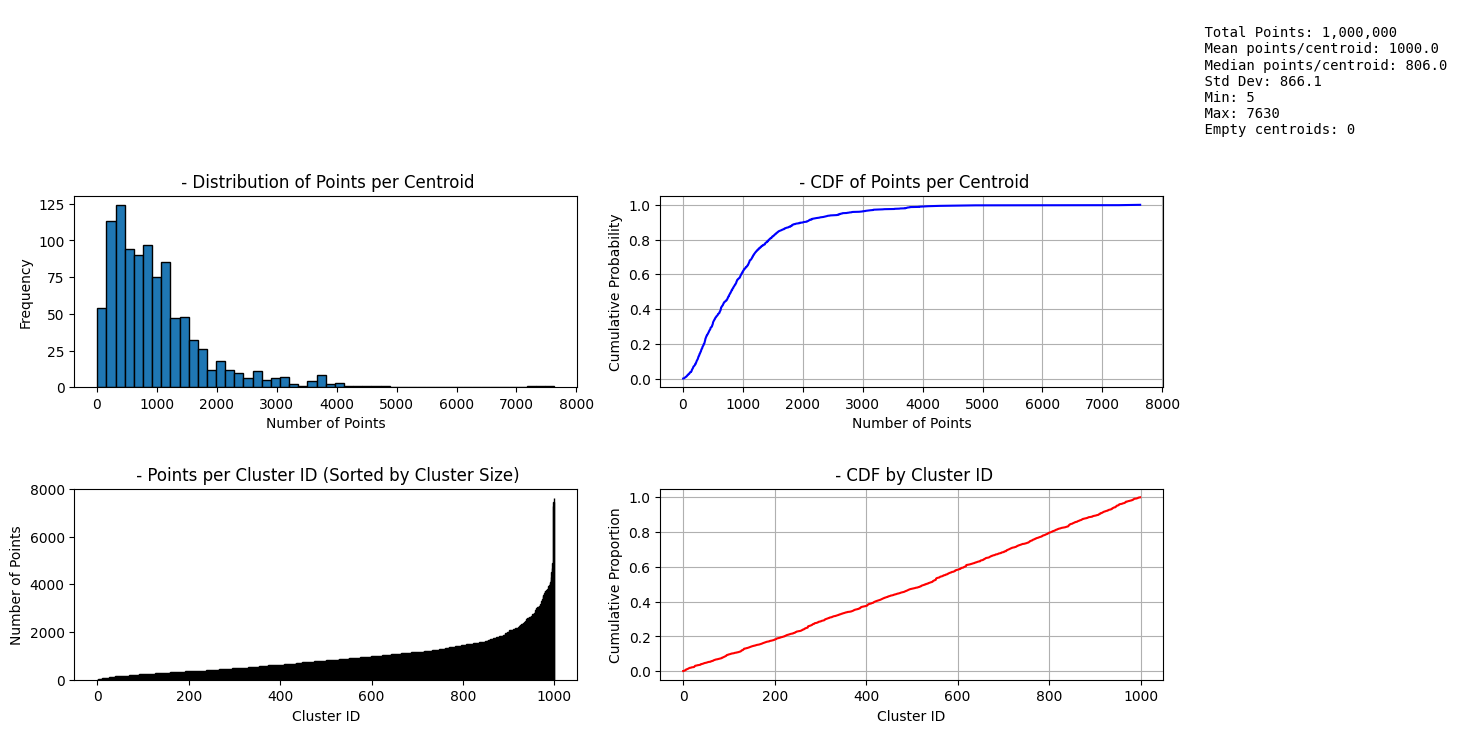

In [ ]:
_ = analyze_cluster_distribution(untrained_index)
_ = analyze_cluster_distribution(untrained_index,plt_sorted=True)
print()
_ = analyze_cluster_distribution(train1_index)
_ = analyze_cluster_distribution(train1_index,plt_sorted=True)
print()
_ = analyze_cluster_distribution(trained_index)
_ = analyze_cluster_distribution(trained_index,plt_sorted=True)
print()
_ = analyze_cluster_distribution(index_to_crack)
_ = analyze_cluster_distribution(index_to_crack,plt_sorted=True)

# Test

In [4]:

def train_ivfflat_l2(
    data,
    nlist=10,
    km_n_iter=10,
    km_max_pts=256,
    seed=1,
    nredo=1,
    verbose=True,
    store_dir=None,
):
    print(f"Training... {nlist=} {km_n_iter=} {km_max_pts=} {seed=} {nredo=}")
    nb, d = data.shape

    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(
        quantizer, d, nlist, faiss.METRIC_L2
    )  # for INNER_PRODUCT use  METRIC_INNER_PRODUCT for angular
    index.cp.seed = seed
    index.cp.niter = km_n_iter
    index.cp.max_points_per_centroid = km_max_pts
    index.cp.nredo = nredo
    index.verbose = verbose

    strain = time.perf_counter()
    index.train(data)
    etrain = time.perf_counter()

    sadd = time.perf_counter()
    index.add(data)
    eadd = time.perf_counter()

    if store_dir is not None:
        filename = (
            store_dir
            + f"/index-n_iter_{km_n_iter}-nlist_{nlist}-max_pts_{km_max_pts}-seed_{seed}.index"
        )
        if args.store:
            print("storing index", filename)
            faiss.write_index(index, filename)
    
    print(f"\t---> Index Train Time = {(etrain - strain)*1000} ms | Add Time = {(eadd - sadd)*1000} ms <---")
    return index, etrain - strain, eadd - sadd


In [6]:
index, train_time, add_time = train_ivfflat_l2(
    xb,
    nlist=1000,
    km_n_iter=0,
    km_max_pts=256,
    seed=42,
    store_dir=None,  # if you want to store the index
    verbose=True,
)

Training... nlist=1000 km_n_iter=0 km_max_pts=256 seed=42 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
	---> Index Train Time = 124.46738700054993 ms | Add Time = 749.2842499996186 ms <---


In [ ]:
index.quantizer.reconstruct_n()
invlists = np.arange(1000)
tmp_pids, tmp_codes = [], []
for invlist_id in invlists:
    point_ids, codes = get_invlist(index.invlists, int(invlist_id)) 
    tmp_pids.append(point_ids)
    tmp_codes.append(codes)
    # if DEBUG:print(f"- In {invlist_id=} => {point_ids=}")
pids_visited = np.concatenate(tmp_pids, axis=0)
points_visited = np.concatenate(tmp_codes, axis=0).view("float32")

array([[ 36.,  14.,  44., ...,  50.,  20.,   6.],
       [ 19.,  10.,  16., ...,   5.,  16.,  39.],
       [ 95.,   2.,   0., ...,  24.,  25.,  13.],
       ...,
       [ 15.,   1.,   2., ...,   2.,  18., 104.],
       [  0.,   0.,   0., ...,   3.,   1.,   0.],
       [ 20.,  22.,  25., ...,   2.,   2.,  13.]], dtype=float32)

In [13]:
import numpy as np

invlists = np.arange(1000)
tmp_pids, tmp_codes = [], []

# Assuming you know the dimensionality of the vectors beforehand (e.g., `dims`)
dims = index.d  # Dimensionality of the vectors in the index
centroids = np.full((len(invlists), dims), np.nan, dtype=np.float32)  # Initialize with NaN

for invlist_id in invlists:
    point_ids, codes = get_invlist(index.invlists, int(invlist_id)) 
    
    # Convert codes to float32 to treat as points
    points = codes.view("float32")
    
    # Calculate centroid for this invlist if it has points
    if points.size > 0:
        centroids[invlist_id] = np.mean(points, axis=0)
    # If empty, the corresponding row in `centroids` remains NaN
    
    # Store point IDs and codes for further processing
    tmp_pids.append(point_ids)
    tmp_codes.append(codes)
    # if DEBUG: print(f"- In {invlist_id=} => {point_ids=}")

pids_visited = np.concatenate(tmp_pids, axis=0)
points_visited = np.concatenate(tmp_codes, axis=0).view("float32")


In [14]:
index.quantizer.reconstruct_n()

array([[ 36.,  14.,  44., ...,  50.,  20.,   6.],
       [ 19.,  10.,  16., ...,   5.,  16.,  39.],
       [ 95.,   2.,   0., ...,  24.,  25.,  13.],
       ...,
       [ 15.,   1.,   2., ...,   2.,  18., 104.],
       [  0.,   0.,   0., ...,   3.,   1.,   0.],
       [ 20.,  22.,  25., ...,   2.,   2.,  13.]], dtype=float32)

In [16]:
centroids

array([[42.150562 , 13.660674 ,  7.34382  , ..., 17.883146 , 11.051685 ,
        15.588764 ],
       [17.584745 , 12.696327 ,  8.241526 , ..., 14.90113  , 22.309322 ,
        37.99859  ],
       [71.159515 , 17.151903 ,  3.3198397, ..., 27.91543  , 29.872545 ,
        12.945891 ],
       ...,
       [27.53935  , 12.245487 ,  9.888086 , ...,  9.54296  , 24.122744 ,
        57.18917  ],
       [ 3.4672022,  1.4979919,  1.4912986, ...,  8.508701 ,  8.574297 ,
         8.029451 ],
       [26.412632 , 25.368422 , 36.562107 , ..., 10.347368 , 10.6231575,
        17.60421  ]], dtype=float32)

In [18]:
ncents, d = centroids.shape
start_time = time.perf_counter()
new_quantizer = faiss.IndexFlatL2(d)
new_quantizer.add(centroids)
_ = replace_ivf_quantizer(index, new_quantizer)
end_time = time.perf_counter()

In [ ]:
import numpy as np
import time
import faiss

